In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1, training
import torch
from torch import optim,nn
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import datasets
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import zipfile 
import torch
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from sklearn.metrics import accuracy_score
import src
from src.utils.celeba_helper import CelebADataset, CelebAClassifier, save_file_names
from imp import reload
import random
from src.utils.loss_functions import NPairLoss
from torch.optim import lr_scheduler

workers = 0 if os.name == 'nt' else 2

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [4]:
## Load the dataset
# Path to directory with all the images
img_folder = 'data/img_align_celeba'
mapping_file = 'data/identity_CelebA.txt'

# Spatial size of training images, images are resized to this size.
image_size = 160
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size), # TODO: Experiment with fixed_image_standardization
    transforms.ToTensor()
])

# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, mapping_file, transform)

In [5]:
## Create a dataloader
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = DataLoader(celeba_dataset,  # type: ignore
                        batch_size=batch_size,
                        num_workers=num_workers,
                        pin_memory=pin_memory,
                        shuffle=False)

# data

<BarContainer object of 34 artists>

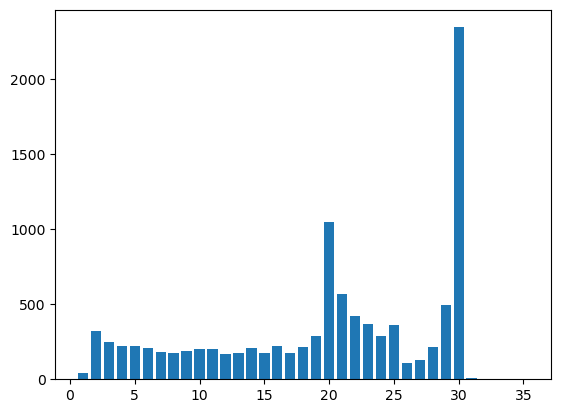

In [6]:
results = pd.value_counts(celeba_dataset.file_label_mapping.person_id)
#plt.hist(results.values)
r = pd.value_counts(results.values)
plt.bar(r.index, r.values)

In [7]:
file_label_mapping = celeba_dataset.get_file_label_mapping()
first_file_for_each_person_df = file_label_mapping.sort_values(by='person_id').groupby('person_id').agg(['min', 'count'])
ids_morethan5 = list(first_file_for_each_person_df[first_file_for_each_person_df['file_name']['count'] > 5].index)


In [8]:
def get_files_from_id(dataset, i):
    return list(dataset.file_label_mapping[dataset.file_label_mapping['person_id']==i]['file_name'].values)


def dict_file2id(mapping):
    file2id = {}
    for index, row in mapping.iterrows():
        file2id[row['file_name']] = row['person_id']
    return file2id

file2id = dict_file2id(celeba_dataset.file_label_mapping)

def dict_id2files(train_files):
    id2files = {}
    for f in train_files:
        l = file2id[f]
        if id2files.get(l) is None:
            id2files[l] = []
        id2files[l].append(f)
    return id2files

In [9]:
def get_img_from_file(dataset, file_name):
    img_path = os.path.join(dataset.root_dir, file_name)
    img = Image.open(img_path).convert("RGB")
    if dataset.transform:
        img = dataset.transform(img)
    return img

In [10]:
ids_train = random.sample(ids_morethan5, 1000)
#ids_all = list(first_file_for_each_person_df.index)
ids_test = [i for i in ids_morethan5 if i not in ids_train]
train_files = []
for i in ids_train:
    train_files += get_files_from_id(celeba_dataset, i)
id2files = dict_id2files(train_files)

In [11]:
batch_size = 128
ids_valid = random.sample(ids_test, 500)
valid_files = []
for i in ids_valid:
    valid_files += get_files_from_id(celeba_dataset, i)
id2files_valid = dict_id2files(valid_files)
valid_batches = []
for cursor in range(0, len(ids_valid), batch_size//2):
    batch_ids = ids_valid[cursor:cursor+batch_size//2]
    batch_img = []
    batch_labels = []

    for i in batch_ids:
        batch_labels += [i,i]
        img2 = random.sample(id2files_valid[i], 2)
        batch_img += [get_img_from_file(celeba_dataset,f) for f in img2]
    
    batch_img = torch.stack(batch_img)
    batch_labels = torch.tensor(batch_labels)
    
    valid_batches.append((batch_img, batch_labels))


In [12]:
def loss_valid(model, valid_batches):
    model.eval()
    result = []
    for batch_img, batch_labels in valid_batches:
        embeddings = model(batch_img)
        loss = criterion(embeddings, batch_labels)
        result.append(loss.cpu().detach().numpy())
    return np.mean(result)

In [16]:
model = InceptionResnetV1(pretrained='vggface2').to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = NPairLoss()

In [17]:
batch_size = 128
epochs = 10
loss_total = []
loss_validation = []
for epoch in range(epochs):
    running_loss = []
    model.train()
    for cursor in tqdm(range(0, len(ids_train), batch_size//2),leave=False, desc='bacth'):
    #while cursor + batch_size//2 <= len(ids_train):
        batch_ids = ids_train[cursor:cursor+batch_size//2]
        #cursor += batch_size//2
        #batch_ids
        # 每个id再随机选择两张图片
        batch_img = []
        batch_labels = []

        for i in batch_ids:
            batch_labels += [i,i]
            img2 = random.sample(id2files[i], 2)
            batch_img += [get_img_from_file(celeba_dataset,f) for f in img2]

        batch_img = torch.stack(batch_img)
        batch_labels = torch.tensor(batch_labels)

        optimizer.zero_grad()
        embeddings = model(batch_img)
        loss = criterion(embeddings, batch_labels)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
        
    loss_total.append(np.mean(running_loss))
    loss_v = loss_valid(model, valid_batches)
    loss_validation.append(loss_v)
    print("Epoch: {}/{} - Loss: {:.4f}       Valid loss: {}".format(epoch, epochs, np.mean(running_loss), loss_v))

Epoch: 0/10 - Loss: 3.6124       Valid loss: 3.5644214153289795


Epoch: 1/10 - Loss: 3.5451       Valid loss: 3.506249189376831


Epoch: 2/10 - Loss: 3.4930       Valid loss: 3.4737277030944824


Epoch: 3/10 - Loss: 3.4638       Valid loss: 3.4544105529785156


Epoch: 4/10 - Loss: 3.4484       Valid loss: 3.442798614501953


Epoch: 5/10 - Loss: 3.4353       Valid loss: 3.435616970062256


Epoch: 6/10 - Loss: 3.4300       Valid loss: 3.4319567680358887


Epoch: 7/10 - Loss: 3.4213       Valid loss: 3.437354803085327


Epoch: 8/10 - Loss: 3.4225       Valid loss: 3.4325528144836426


Epoch: 9/10 - Loss: 3.4110       Valid loss: 3.4337430000305176


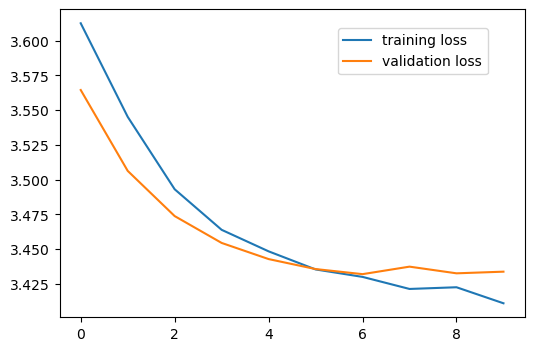

In [31]:
x = list(range(10))
fig = plt.figure(figsize=(6,4))
plt.plot(x, loss_total)
plt.plot(x, loss_validation)

fig.legend(labels=['training loss','validation loss'])
sns.move_legend(obj=fig, loc="upper right", bbox_to_anchor=(.85, .85), title='')